In [15]:
%matplotlib inline
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import copy
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [4]:
#del cnn
torch.cuda.empty_cache()
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Dael Klang/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [7]:
STYLE_LAYERS_TRANSLATION = {'conv_1': 'conv1_1',
                            'conv_2': 'conv1_2',

                            'conv_3': 'conv2_1',
                            'conv_4': 'conv2_2',

                            'conv_5': 'conv3_1',
                            'conv_6': 'conv3_2',
                            'conv_7': 'conv3_3',
                            'conv_8': 'conv3_4',

                            'conv_9': 'conv4_1',
                            'conv_10': 'conv4_2',
                            'conv_11': 'conv4_3',
                            'conv_12': 'conv4_4',

                            'conv_13': 'conv5_1',
                            'conv_14': 'conv5_2',
                            'conv_15': 'conv5_3',
                            'conv_16': 'conv5_4'}

# ====================



In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# ====================

In [9]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

#GAUSSIAN_BLUR = 8

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name) #.convert('RGB')
    #image = image.filter(ImageFilter.GaussianBlur(GAUSSIAN_BLUR))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/starry_night_full.jpg")
#content_img = image_loader("./images/.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

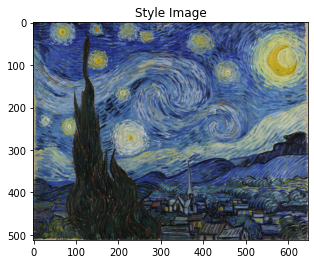

In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, title):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(title)

plt.figure()
imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [ ]:
# class ContentLoss(nn.Module):

#     def __init__(self, target,):
#         super(ContentLoss, self).__init__()
#         # we 'detach' the target content from the tree used
#         # to dynamically compute the gradient: this is a stated value,
#         # not a variable. Otherwise the forward method of the criterion
#         # will throw an error.
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input

In [11]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, #content_img,
                               #content_layers,
                               style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
#     content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      

        model.add_module(name, layer)

#         if name in content_layers:
#             # add content loss:
#             target = model(content_img).detach()
#             content_loss = ContentLoss(target)
#             model.add_module("content_loss_{}".format(i), content_loss)
#             content_losses.append(content_loss)

        if name.startswith('conv') and STYLE_LAYERS_TRANSLATION[name] in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss): #or isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses#, content_losses

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    # optimizer = optim.Adam([target], lr=0.003)
    return optimizer

In [24]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       #content_img, 
                       style_img, input_img,
                       style_layers, style_weights,
                       num_steps=300, style_weight=1000000):#, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
#     model, style_losses, content_losses = get_style_model_and_losses(cnn,
    model, style_losses = get_style_model_and_losses(cnn, 
        normalization_mean, normalization_std, style_img, style_layers)#, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    losses = []
    start_time = [time.time()]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
#             content_score = 0

            for i, sl in enumerate(style_losses):
                style_score += style_weights[i] * sl.loss
#             for cl in content_losses:
#                 content_score += cl.loss

            style_score *= style_weight
#             content_score *= content_weight

            loss = style_score # + content_score
            losses.append(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:\t\tStyle loss: {:4f}".format(run, style_score.item()),end="\t\t")
                print(f"Time: {time.time()-start_time[0]}")
                start_time[0] = time.time()
#                 print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                     style_score.item(), content_score.item()))
                #print('Style Loss : {:4f} '.format(style_score.item()))
                #print()
            if run[0] % 500 == 0:
                vis_img = copy.deepcopy(input_img)
                plt.figure()
                imshow(vis_img, title=f'On run {run[0]}')
        
            return style_score #+ content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img, losses

torch.Size([1, 3, 512, 646])


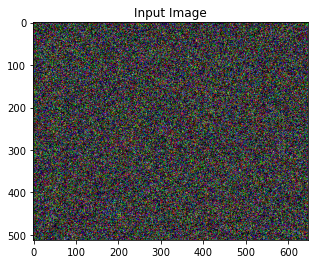

In [52]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
base_img = torch.randn(style_img.data.size(), device=device)
base_img = torch.poisson(base_img) #torch.zeros_like(style_img, device=device) #
print(style_img.shape)
#base_img[0,:,0:250,:] = 1
# add the original input image to the figure:
plt.figure()
imshow(base_img, title='Input Image')

Building the style transfer model..


D:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
D:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:		Style loss: 6.596765	The training process took 7.381593942642212
run [100]:		Style loss: 2.660941	The training process took 9.122919797897339
run [150]:		Style loss: 1.624815	The training process took 10.013980865478516
run [200]:		Style loss: 1.253439	The training process took 10.062334775924683
run [250]:		Style loss: 1.003537	The training process took 10.073361873626709
run [300]:		Style loss: 0.715618	The training process took 10.044177055358887
run [350]:		Style loss: 0.401198	The training process took 10.439143896102905
run [400]:		Style loss: 0.177113	The training process took 10.32403564453125
run [450]:		Style loss: 0.064903	The training process took 10.404606342315674
run [500]:		Style loss: 0.028786	The training process took 10.507810354232788


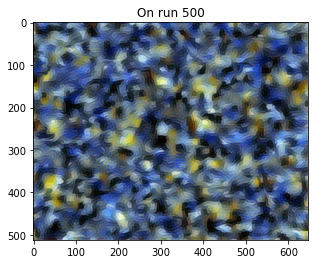

run [550]:		Style loss: 0.016907	The training process took 10.75026822090149
run [600]:		Style loss: 0.011539	The training process took 10.355950832366943
run [650]:		Style loss: 0.008745	The training process took 11.143167734146118
run [700]:		Style loss: 0.006817	The training process took 10.439928770065308
run [750]:		Style loss: 0.005590	The training process took 10.419694185256958
run [800]:		Style loss: 0.004590	The training process took 10.26555609703064
run [850]:		Style loss: 0.003845	The training process took 10.419433832168579
run [900]:		Style loss: 0.003238	The training process took 10.954427003860474
run [950]:		Style loss: 0.002734	The training process took 11.080605268478394
run [1000]:		Style loss: 0.002304	The training process took 12.528478622436523


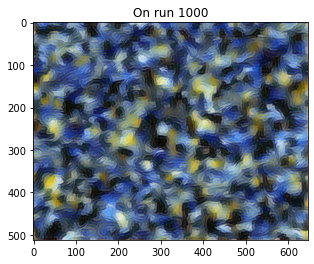

run [1050]:		Style loss: 0.001954	The training process took 13.530818700790405
run [1100]:		Style loss: 0.001677	The training process took 11.448991060256958
run [1150]:		Style loss: 0.001429	The training process took 10.843177795410156
run [1200]:		Style loss: 0.001240	The training process took 10.361403465270996
run [1250]:		Style loss: 0.001088	The training process took 10.271820306777954
run [1300]:		Style loss: 0.000970	The training process took 10.312604188919067
run [1350]:		Style loss: 0.000852	The training process took 10.916720390319824
run [1400]:		Style loss: 0.000763	The training process took 11.290157318115234
run [1450]:		Style loss: 0.000685	The training process took 10.367119550704956
run [1500]:		Style loss: 0.000617	The training process took 10.463064670562744


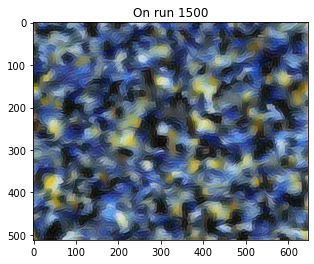

run [1550]:		Style loss: 0.000556	The training process took 10.79802393913269
run [1600]:		Style loss: 0.000506	The training process took 10.58904504776001
run [1650]:		Style loss: 0.000469	The training process took 10.907686948776245
run [1700]:		Style loss: 0.000429	The training process took 10.46620488166809
run [1750]:		Style loss: 0.000395	The training process took 10.54634714126587
run [1800]:		Style loss: 0.000366	The training process took 10.511033058166504
run [1850]:		Style loss: 0.000342	The training process took 10.680819272994995
run [1900]:		Style loss: 0.000319	The training process took 10.598735332489014
run [1950]:		Style loss: 0.000301	The training process took 10.254777193069458
run [2000]:		Style loss: 0.000283	The training process took 10.418185710906982


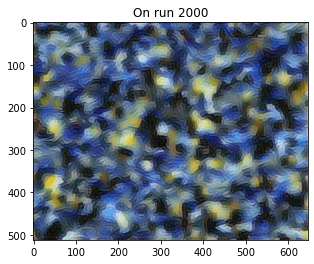

run [2050]:		Style loss: 0.000267	The training process took 11.151833534240723
run [2100]:		Style loss: 0.000250	The training process took 10.802144765853882
run [2150]:		Style loss: 0.000235	The training process took 10.640717029571533
run [2200]:		Style loss: 0.000221	The training process took 12.12963342666626
run [2250]:		Style loss: 0.000208	The training process took 10.857113599777222
run [2300]:		Style loss: 0.000195	The training process took 10.435455322265625
run [2350]:		Style loss: 0.000184	The training process took 10.988934755325317
run [2400]:		Style loss: 0.000174	The training process took 10.46132230758667


KeyboardInterrupt: 

In [54]:

input_img = copy.deepcopy(base_img)

STYLE_LAYERS = ['conv1_1', 'conv2_1']#, 'conv3_1', 'conv4_1', 'conv5_1']#, 'conv_3', 'conv_4', 'conv_5']
# STYLE_LAYERS = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8']
STYLE_WEIGHTS = np.array([1,0.75,0.2,0.2,0.2])
# STYLE_WEIGHTS = np.ones(len(STYLE_LAYERS))
EPOCHS = 3000
start_time = time.time()
output, losses = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, 
                            style_img, input_img,  
                            STYLE_LAYERS, STYLE_WEIGHTS,
                            num_steps=EPOCHS)
end_time = time.time()
print(f"The training process took {end_time-start_time}")

plt.figure()
imshow(output, title='Output Image')

fig = plt.figure(figsize=(16,10))
fig.add_subplot(2,2,1)
plt.plot(losses) 
plt.title('Losses vs Iter')
fig.add_subplot(2,2,2)
plt.plot(np.log10(losses)) 
plt.title('log10(Losses) vs Iter')
fig.add_subplot(2,2,3)
plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
plt.title('Zoomed Losses vs Iter')
fig.add_subplot(2,2,4)
plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
plt.title('Zoomed log10(Losses) vs Iter')

imsave(output, f'outputs/poiss_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
fig.savefig(f'outputs/poiss_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

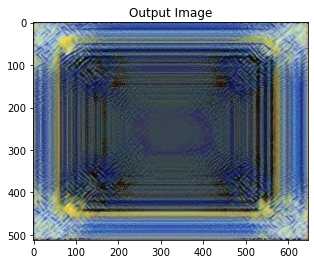

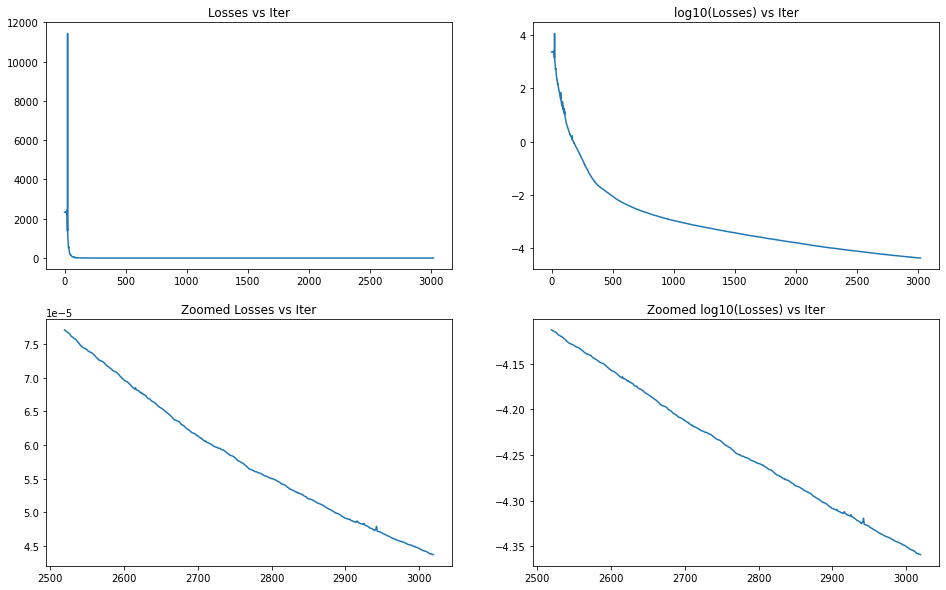

In [41]:
# a = copy.deepcopy(output)
# imshow(output-a, title='Sub Img')
#imsave(output, f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
# fig = plt.figure(figsize=(18,10))
# fig.add_subplot(2,2,1)
# plt.plot(losses) 
# plt.title('Losses vs Iter')
# fig.add_subplot(2,2,2)
# plt.plot(np.log10(losses)) 
# plt.title('log10(Losses) vs Iter')
# fig.add_subplot(2,2,3)
# plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
# plt.title('Zoomed Losses vs Iter')
# fig.add_subplot(2,2,4)
# plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
# plt.title('Zoomed log10(Losses) vs Iter')
# fig.savefig(f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')
plt.figure()
imshow(output, title='Output Image')

fig = plt.figure(figsize=(16,10))
fig.add_subplot(2,2,1)
plt.plot(losses) 
plt.title('Losses vs Iter')
fig.add_subplot(2,2,2)
plt.plot(np.log10(losses)) 
plt.title('log10(Losses) vs Iter')
fig.add_subplot(2,2,3)
plt.plot(np.arange(len(losses))[-500:], losses[-500:]) 
plt.title('Zoomed Losses vs Iter')
fig.add_subplot(2,2,4)
plt.plot(np.arange(len(losses))[-500:], np.log10(losses[-500:])) 
plt.title('Zoomed log10(Losses) vs Iter')

#imsave(output, f'outputs/black_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
#fig.savefig(f'outputs/black_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [22]:
%qtconsole